In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
#%%
from ntm import NTM
from dataloader import copy_dataloader
from torch import nn, optim
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
#%%

In [9]:
input_size=8+2
output_size=8
controller_size=100
memory_units=128
memory_unit_size=20
batch_size=1
num_heads=1
total_iteration =10000
num_batches = total_iteration//batch_size 

In [10]:
device = torch.device("cpu")
data = copy_dataloader(num_batches,batch_size,8,1,20,device)

ntm = NTM(input_size,output_size,controller_size,memory_units,memory_unit_size,num_heads)

criterion = nn.BCELoss()
optimizer = optim.RMSprop(ntm.parameters(),
                          lr=1e-4,
                          alpha=0.95,
                          momentum=0.9)

In [14]:
#%%
print("Starting training")
print_every = 100
losses =[]
errors =[]
for batch, (x,y) in enumerate(data):
    optimizer.zero_grad()
    ntm.reset(batch_size)
    
#     print("Sendning inputs")
    for i in range(x.size(0)):
        input = x[i]
        ntm(input)

    outputs = torch.zeros(y.size())

    zero_input = torch.zeros([batch_size,input_size])
#     print("Finding Outputs")
    for i in range(y.size(0)):
        outputs[i] = ntm(zero_input)
    
#     print("Backprop step")
    loss = criterion(outputs, y)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_value_(ntm.parameters(), 10)
    optimizer.step()
    
    out_binarized = outputs.clone().data
    out_binarized = out_binarized.detach().apply_(lambda x: 0 if x < 0.5 else 1)
    
    # The cost is the number of error bits per sequence
    cost = torch.sum(torch.abs(out_binarized - y.data))
    errors.append(cost.item()/batch_size)
    if (batch%print_every ==0):
        print(f"Finished batch: {batch}, loss:{losses[-1]:.3e}, cost: {errors[-1]}")
        #torch.save(ntm, f'checkpoints/i-{batch}_error_{losses[-1]:.3e}.pt')

Starting training
Finished batch: 0, loss:6.576e-01, cost: 39.0


KeyboardInterrupt: 

In [13]:
ntm =(torch.load("checkpoints/i-9900_error_0.000e+00.pt"))

C:\Users\Ananth Mahadevan\.conda\envs\torch\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTMCell' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Ananth Mahadevan\.conda\envs\torch\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Ananth Mahadevan\.conda\envs\torch\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the ori

In [97]:
test = copy_dataloader(1,1,8,140,140,device)
x,y = next(test)


In [98]:
mpl.rcParams['figure.dpi']=300

## Target sequence

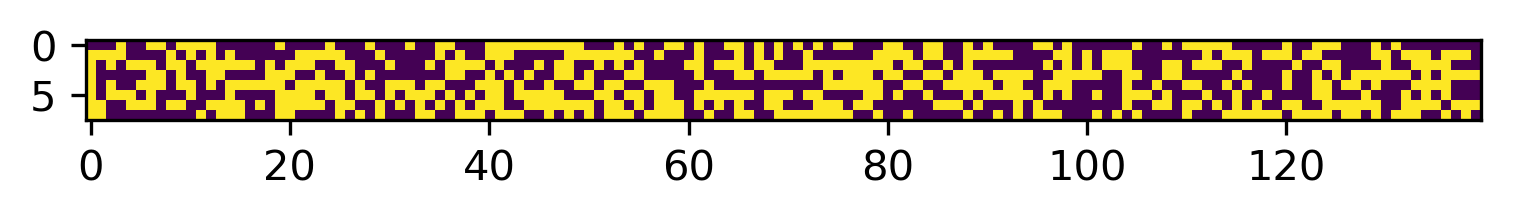

In [99]:
plt.imshow(y.squeeze().t())

In [100]:
ntm.reset(batch_size=1)
with torch.no_grad():
    for i in range(x.size(0)):
            input = x[i]
            ntm(input)
    outputs = torch.zeros(y.size())

    zero_input = torch.zeros([1,input_size])
    #     print("Finding Outputs")
    for i in range(y.size(0)):
        outputs[i] = ntm(zero_input)




## Output from network 

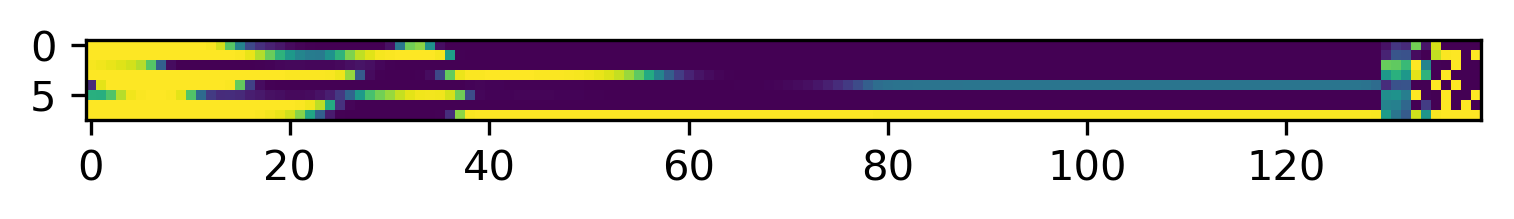

In [101]:
plt.imshow(outputs.squeeze().t())

## Error between target and output

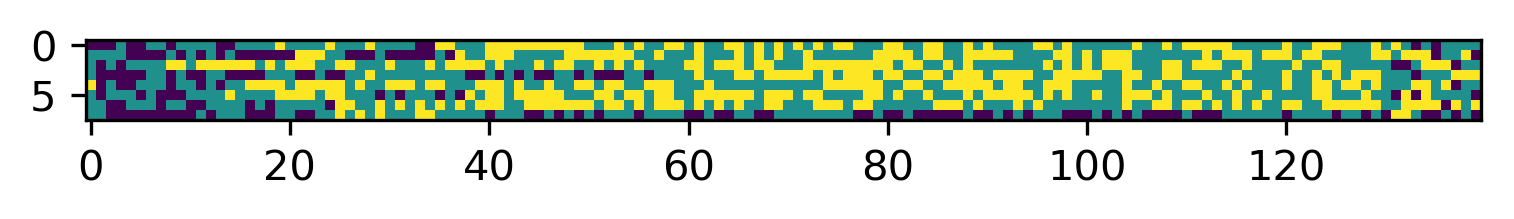

In [102]:
plt.imshow((y-outputs).round().squeeze().t())